In [1]:
import numpy as np 
from pathlib import Path
from src import utils, behavmatch, db
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import sem
import seaborn as sns
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import rcParams
default_font = 12
fs_title = 14
rcParams["font.family"] = "Arial"
rcParams["savefig.dpi"] = 300
rcParams["axes.spines.top"] = False
rcParams["axes.spines.right"] = False
rcParams["axes.titlelocation"] = "left"
rcParams["axes.titleweight"] = "normal"
rcParams["font.size"] = default_font
trial_type_palette = ['tab:green', 'tab:red', 'tab:cyan', 'tab:orange'] #rew #nrew #rew_test #nrew_test #GI
from IPython.display import clear_output
areas = ["V1", "medial", "lateral", "anterior"]
ttypes = ["rewarded", "non rewarded", "rewarded test", "non rewarded test"]
ctypes = ["exc", "inh"]
corridor_length = 400
main_dir = Path(f"../data/notz/overall")

In [2]:
dbase = db.get_sessions()
lday = dbase.query("session == 'last training'")
mice = []
for i, row in lday.iterrows():
    name, date, blk = row['mname'], row["datexp"], row["blk"]
    m = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path=r"D:\mouseobj\notz")
    mice.append(m)
    clear_output(wait=True)
print("last training sessions loaded")

last training sessions loaded


In [3]:
def get_errordict(m, ttypes):
    error_dict = {}
    for _type in ttypes:
        t_licks, t_no_licks = utils.get_trials_with_licks(m, trialtype=_type)
        if _type in ["rewarded", "rewarded test"]:
            error_dict[_type] = t_no_licks
        elif _type in ["non rewarded", "non rewarded test"]:
            error_dict[_type] = t_licks
    error_dict["IO"] = np.concatenate([error_dict["rewarded"], error_dict["rewarded test"]])
    error_dict["FA"] = np.concatenate([error_dict["non rewarded"], error_dict["non rewarded test"]])
    return error_dict

def get_corectdict(m, ttypes):
    correct_dict = {}
    for _type in ttypes:
        t_licks, t_no_licks = utils.get_trials_with_licks(m, trialtype=_type)
        if _type in ["rewarded", "rewarded test"]:
            correct_dict[_type] = t_licks
        elif _type in ["non rewarded", "non rewarded test"]:
            correct_dict[_type] = t_no_licks
    correct_dict["RC"] = np.concatenate([correct_dict["rewarded"], correct_dict["rewarded test"]])
    correct_dict["CO"] = np.concatenate([correct_dict["non rewarded"], correct_dict["non rewarded test"]])
    return correct_dict

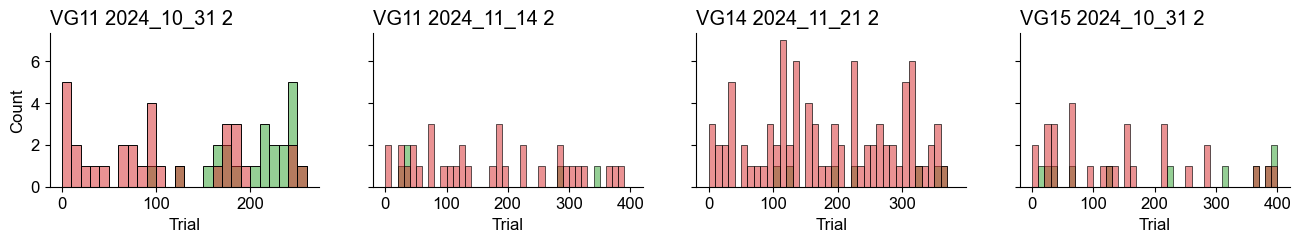

In [185]:
import seaborn as sns
fig, ax = plt.subplots(1, 4, figsize=(16, 2), sharey=True)
for im, m in enumerate(mice):
    errors = get_errordict(m, ttypes)
    lick_df = utils.get_lick_df(m)
    last_trial = lick_df.trial.astype(int).max()
    bins=np.arange(0, last_trial+10, 10)
    sns.histplot(errors["IO"], color="tab:green", label="IR", bins=bins, alpha=0.5, ax=ax[im])
    sns.histplot(errors["FA"], color="tab:red", label="FA", bins=bins, alpha=0.5, ax=ax[im])
    ax[im].set_title(f"{m.name} {m.datexp} {m.blk}")
    ax[im].set_xlabel("Trial")

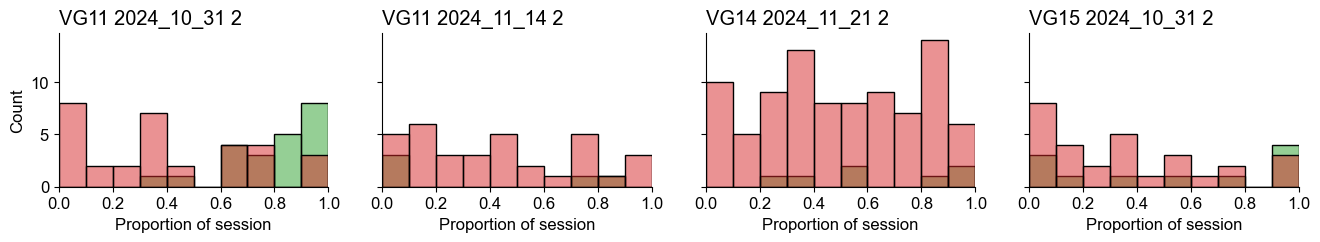

In [186]:
import seaborn as sns
fig, ax = plt.subplots(1, 4, figsize=(16, 2), sharey=True)
n_bins = 10  # or any number of bins you want
for im, m in enumerate(mice):
    errors = get_errordict(m, ttypes)
    lick_df = utils.get_lick_df(m)
    last_trial = lick_df.trial.astype(int).max()
    # Normalize trial numbers to [0, 1]
    ir_norm = errors["IO"] / last_trial
    fa_norm = errors["FA"] / last_trial
    bins = np.linspace(0, 1, n_bins + 1)
    sns.histplot(ir_norm, color="tab:green", label="IR", bins=bins, alpha=0.5, ax=ax[im])
    sns.histplot(fa_norm, color="tab:red", label="FA", bins=bins, alpha=0.5, ax=ax[im])
    ax[im].set_xlabel("Proportion of session")
    ax[im].set_xlim(0, 1)
    ax[im].set_title(f"{m.name} {m.datexp} {m.blk}")

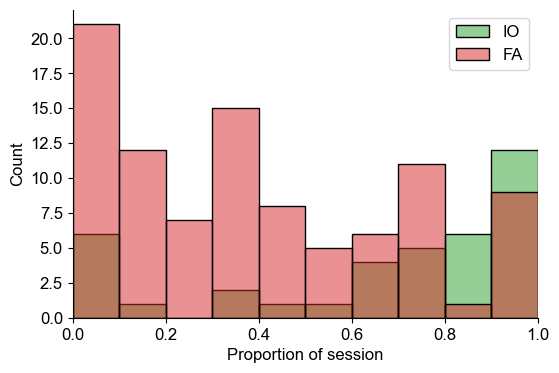

In [190]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(6, 4))
n_bins = 10

all_ir = []
all_fa = []
for im, m in enumerate(mice):
    if im == 2:
        continue
    else:
        errors = get_errordict(m, ttypes)
        lick_df = utils.get_lick_df(m)
        last_trial = lick_df.trial.astype(int).max()
        all_ir.append(errors["IO"] / last_trial)
        all_fa.append(errors["FA"] / last_trial)

all_ir = np.concatenate(all_ir)
all_fa = np.concatenate(all_fa)
bins = np.linspace(0, 1, n_bins + 1)

sns.histplot(all_ir, color="tab:green", label="IO", bins=bins, alpha=0.5, ax=ax)
sns.histplot(all_fa, color="tab:red", label="FA", bins=bins, alpha=0.5, ax=ax)
ax.set_xlabel("Proportion of session")
ax.set_xlim(0, 1)
ax.legend()

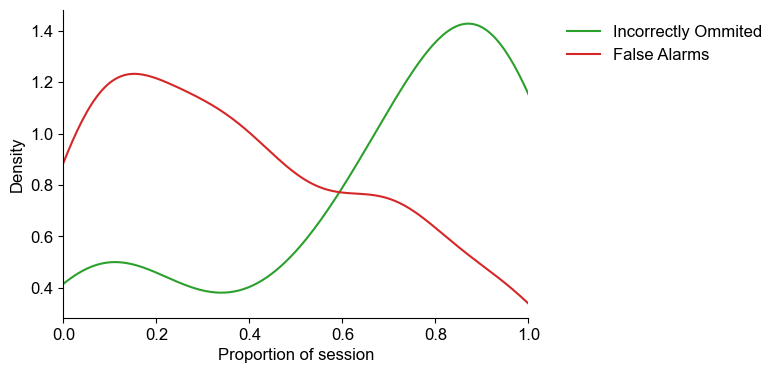

In [191]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.kdeplot(all_ir, color="tab:green", label="Incorrectly Ommited", clip=(0,1), ax=ax)
sns.kdeplot(all_fa, color="tab:red", label="False Alarms", clip=(0,1), ax=ax)
ax.set_xlabel("Proportion of session")
ax.set_xlim(0, 1)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

In [195]:
m = mice[0]
lick_df = utils.get_lick_df(m)
correct, incorrect = utils.build_correct_dicts(m, lick_window=(150,250), onlytest=False)
fa_trials = np.concatenate([incorrect["non rewarded"], incorrect["non rewarded test"]])
io_trials = np.concatenate([incorrect["rewarded"], incorrect["rewarded test"]])
co_trials = np.concatenate([correct["non rewarded"], correct["non rewarded test"]])
rc_trials = np.concatenate([correct["rewarded"], correct["rewarded test"]])

In [5]:
def get_response_centered(m, nomean=False):
    between_intertrials = np.empty((m.interp_spks.shape[0], m.interp_spks.shape[1], m.interp_spks.shape[2] + 100))
    ## gets the trial, with pre a post intertrial periods
    if nomean:
        interp_spks = m.interp_spks - np.mean(m.interp_spks, axis=1, keepdims=True)
    else:
        interp_spks = m.interp_spks
    for i in range(between_intertrials.shape[1]):
        if i == 0: # just to keep shape consistency this trial is ignored
            intertrial = interp_spks[:, :, 300:400]
            intertrial_mean = np.mean(intertrial, axis=1)
            between_intertrials[:, i, :100] = intertrial_mean # inputting the mean of the intertrial period
            between_intertrials[:, i, 100:] = interp_spks[:, i, :]
        else:
            between_intertrials[:, i, :100] = interp_spks[:, i-1,300:400]
            between_intertrials[:, i, 100:] = interp_spks[:, i, :]
    return between_intertrials

def dprime_cell(response, condition1, condition2, discrimination_region=(0,125), subpop=None):
    """
    Compute the d-prime for a single cell.
    """
    response = response[:,:,discrimination_region[0]:discrimination_region[1]].mean(2)
    r1 = response[:, condition1]
    r2 = response[:, condition2]
    if subpop is not None:
        r1 = r1[subpop]
        r2 = r2[subpop]
    # collect means and stds
    mu1 = r1.mean(1)
    mu2 = r2.mean(1)
    std1 = r1.std(1) + np.finfo(np.float64).tiny
    std2 = r2.std(1) + np.finfo(np.float64).tiny
    #compute the train dprime
    dp = 2 * ((mu1 - mu2) / (std1 + std2))
    return dp

def select_neurons(m, area: str, celltype:str, dprime = None, dptsh=95):
    ia = utils.get_region_idx(m.iarea, area)
    assert celltype in ['exc', 'inh'], "celltype must be either 'exc' or 'inh'"
    selected_type = np.logical_not(m.isred[:,0]).astype(bool) if celltype == 'exc' else m.isred[:,0].astype(bool)
    if dprime is None:
        pstv_tsh, ngtv_tsh = utils.get_dp_thresholds(m.train_dp[ia*selected_type], tsh=dptsh) #tresh based on the area
    else:
        pstv_tsh, ngtv_tsh = utils.get_dp_thresholds(dprime[ia*selected_type], tsh=dptsh)
    prefer_r = (m.train_dp>=pstv_tsh)
    prefer_nr = (m.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia * selected_type
    area_prefer_nr = prefer_nr * ia * selected_type
    return area_prefer_r, area_prefer_nr, selected_type, ia

def plot_error_comparison(m, centered_response, areas, ctypes, dp, correct_trials, incorrect_trials, color="tab:green", labels=("correctly ommited", "false alarms")):
    from scipy.stats import sem
    fig, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
    fig.suptitle(f"{m.name} {m.datexp} {m.blk} - Error comparison", fontsize=fs_title)
    for ia, area in enumerate(areas):
        ax[0,ia].set_title(f"{area}")
        ax[1,ia].set_xlabel("Position (cm)")
        for itype, ctype in enumerate(ctypes):
            area_prefer_r, area_prefer_nr, _, _ = select_neurons(m, area, ctype, dprime=dp)
            cd_centered = centered_response[area_prefer_r].mean(0) - centered_response[area_prefer_nr].mean(0)
            ### collect means and sems
            correct_mean = cd_centered[correct_trials,:].mean(0)
            incorrect_mean = cd_centered[incorrect_trials,:].mean(0)
            correct_sem = sem(cd_centered[correct_trials,:], axis=0)
            incorrect_sem = sem(cd_centered[incorrect_trials,:], axis=0)


            ax[itype,ia].plot(correct_mean, color=color, label=labels[0])
            ax[itype,ia].fill_between(np.arange(500), correct_mean+correct_sem, correct_mean-correct_sem,
                                    color=color, alpha=0.2)
            ax[itype,ia].plot(incorrect_mean, color=color, label=labels[1], linestyle="--")
            ax[itype,ia].fill_between(np.arange(500), incorrect_mean+incorrect_sem, incorrect_mean-incorrect_sem,
                                    color=color, alpha=0.2)
            ax[itype,ia].axhline(0, color="k", linestyle="--")
            ax[itype,ia].axvline(100, color="k", linestyle="--")
            ax[itype,0].set_ylabel(f"{ctype} cd (a.u.)")    
    ax[0,-1].legend(loc="upper left", frameon=False, bbox_to_anchor=(1, 1))

In [226]:
m = mice[3]
lick_df = utils.get_lick_df(m)
correct, incorrect = utils.build_correct_dicts(m, lick_window=(150,250), onlytest=False)
fa_trials = np.concatenate([incorrect["non rewarded"], incorrect["non rewarded test"]])
io_trials = np.concatenate([incorrect["rewarded"], incorrect["rewarded test"]])
co_trials = np.concatenate([correct["non rewarded"], correct["non rewarded test"]])
rc_trials = np.concatenate([correct["rewarded"], correct["rewarded test"]])
centered_response = get_response_centered(m, nomean=True)
trial_dict = utils.get_trialno_bytype(m.frameselector)
dp = dprime_cell(centered_response, trial_dict["rewarded"][::2], 
                 trial_dict["non rewarded"][::2], discrimination_region=(100, 200))

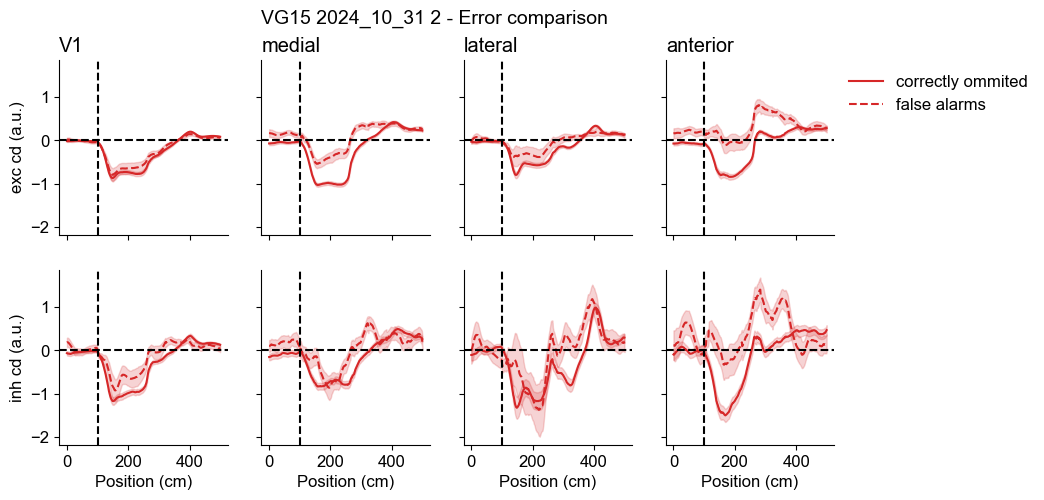

In [232]:
plot_error_comparison(m, centered_response, areas, ctypes, dp, co_trials, fa_trials, 
                      color="tab:red", labels=("correctly ommited", "false alarms"))

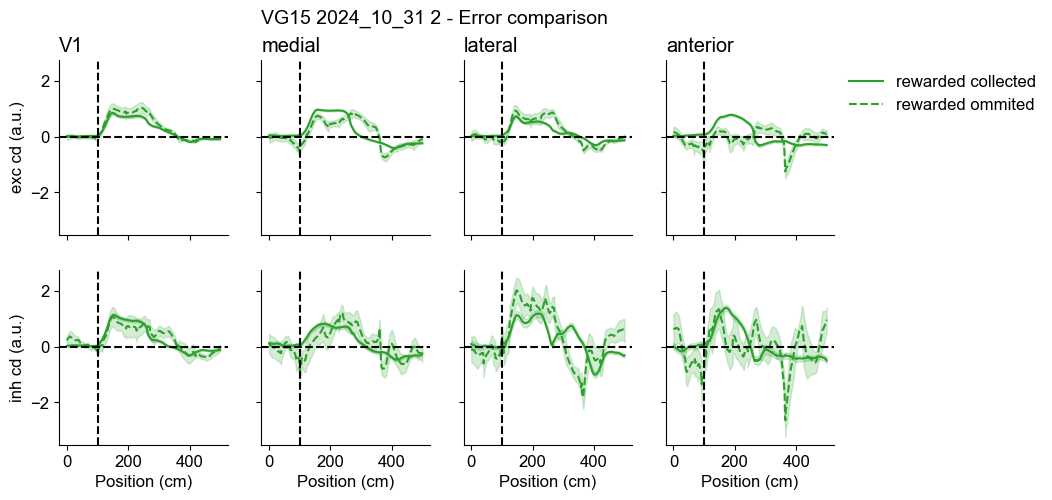

In [ ]:
plot_error_comparison(m, centered_response, areas, ctypes, dp, rc_trials, io_trials, 
                      color="tab:green", labels=("rewarded collected", "rewarded ommited"))

In [250]:
def acf_errors(m, errortype: str, maxlag=15):
    from statsmodels.tsa.stattools import acf
    lick_df = utils.get_lick_df(m)
    correct, incorrect = utils.build_correct_dicts(m, lick_window=(150,250), onlytest=False)
    ntrials = lick_df.trial.astype(int).max()
    errors = np.zeros(ntrials)
    if errortype == "FA":
        errors[incorrect["non rewarded"]] = 1
        errors[incorrect["non rewarded test"]] = 1
    elif errortype == "IO":
        errors[incorrect["rewarded"]] = 1
        errors[incorrect["rewarded test"]] = 1
    else:
        raise ValueError("errortype must be either 'FA' or 'OR'")
    autocorr, inter = acf(errors, nlags=maxlag, fft=False, alpha=0.05)
    return autocorr, inter

In [260]:
m = mice[3]
acf_fa, inter_fa = acf_errors(m, "FA")
acf_io, inter_io = acf_errors(m, "IO")

Text(0.0, 1.0, 'Incorrectly Ommited')

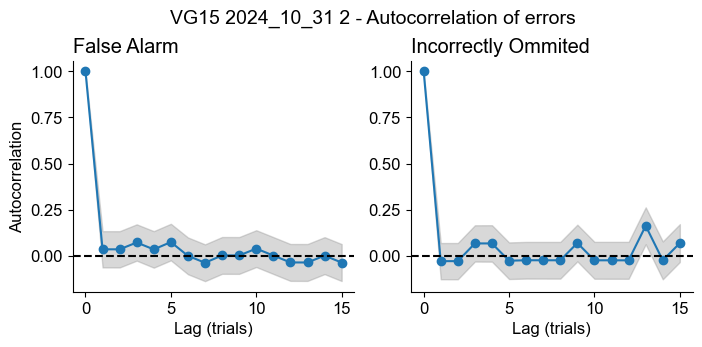

In [261]:
max_lag = 15
plt.figure(figsize=(8,3))
plt.suptitle(f"{m.name} {m.datexp} {m.blk} - Autocorrelation of errors", fontsize=fs_title, y=1.05)
plt.subplot(121)
plt.plot(acf_fa, marker='o', label='Real ACF')
plt.fill_between(range(max_lag + 1), inter_fa[:,0], inter_fa[:,1], color='gray', alpha=0.3)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Lag (trials)")
plt.ylabel("Autocorrelation")
plt.title(f"False Alarm ")
plt.subplot(122, sharey=plt.gca())
plt.plot(acf_io, marker='o', label='Real ACF')
plt.fill_between(range(max_lag + 1), inter_io[:,0], inter_io[:,1], color='gray', alpha=0.3)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Lag (trials)")
plt.title(f"Incorrectly Ommited")

HMM from intertrial

In [4]:
def center_feature(m, feature):
    between_intertrials = np.empty((m.interp_spks.shape[1], m.interp_spks.shape[2] + 100))
    ## gets the trial, with pre a post intertrial periods
    for i in range(feature.shape[0]):
        if i == 0: # just to keep shape consistency this trial is ignored
            intertrial = feature[:, 300:400]
            intertrial_mean = np.mean(intertrial, axis=0)
            between_intertrials[i, :100] = intertrial_mean # inputting the mean of the intertrial period
            between_intertrials[i, 100:] = feature[i, :]
        else:
            between_intertrials[i, :100] = feature[i-1, 300:400]
            between_intertrials[i, 100:] = feature[i, :]
    return between_intertrials

In [50]:
m = mice[3]
speed, lick_rate, delta_motion, delta_pupil = behavmatch.load_behav_data(m, delta=True)
acc = behavmatch.compute_acceleration(speed, ew=.2)
centered_speed = center_feature(m, speed)
centered_lick_rate = center_feature(m, lick_rate)
centered_acc = center_feature(m, acc)
centered_delta_motion = center_feature(m, delta_motion)
centered_delta_pupil = center_feature(m, delta_pupil)
correct, incorrect = utils.build_correct_dicts(m, lick_window=(150,250), onlytest=False)
trial_dict = utils.get_trialno_bytype(m.frameselector)
correct_trials = np.concatenate([correct["rewarded"], correct["rewarded test"], correct["non rewarded"], correct["non rewarded test"]])
outcome = np.zeros(centered_speed.shape[0])
outcome[correct_trials] = 1
category = np.zeros(centered_speed.shape[0])
category[np.concatenate([trial_dict["rewarded"], trial_dict["rewarded test"]])] = 1

In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
X = pd.DataFrame({"speed": centered_speed[:,:100].mean(1), 
            "lick_rate": centered_lick_rate[:,:100].mean(1),
            "acceleration": centered_acc[:,:100].mean(1), 
            "delta_motion": centered_delta_motion[:,:100].mean(1),
            "delta_pupil": centered_delta_pupil[:,:100].mean(1), 
            "outcome": outcome,
            "category": category
})


In [52]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.drop(columns=["outcome","category"]))
model = GaussianHMM(n_components=2, covariance_type='full', n_iter=600)
model.fit(X_scaled)
X.loc[X.index, 'iti_state'] = model.predict(X_scaled)

c:\Users\labadmin\anaconda3\envs\categoryneural\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


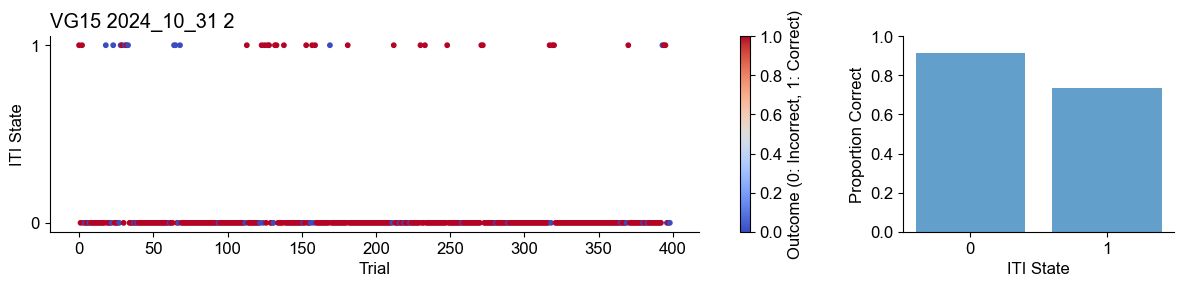

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3), gridspec_kw={'width_ratios': [3, 1]})

# Left: State across trials colored by outcome
sc = ax1.scatter(X.index, X['iti_state'], c=X['outcome'], cmap='coolwarm', s=10)
ax1.set_xlabel('Trial')
ax1.set_ylabel('ITI State')
ax1.set_title(f'{m.name} {m.datexp} {m.blk}')
ax1.set_yticks(sorted(X['iti_state'].unique()))
plt.colorbar(sc, ax=ax1, label='Outcome (0: Incorrect, 1: Correct)')

# Right: Proportion of correct trials per state
state_vals = np.sort(X['iti_state'].unique())
prop_correct = [X.loc[X['iti_state'] == s, 'outcome'].mean() for s in state_vals]
ax2.bar(state_vals, prop_correct, color='tab:blue', alpha=0.7)
ax2.set_xticks(state_vals)
ax2.set_ylim(0, 1)
ax2.set_xlabel('ITI State')
ax2.set_ylabel('Proportion Correct')


plt.tight_layout()
plt.show()

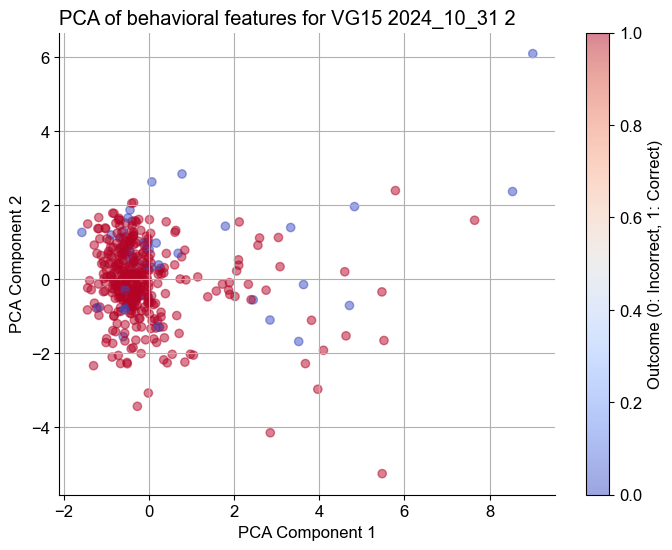

In [54]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.drop(columns=["outcome","category"]))
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=X["outcome"], cmap='coolwarm', alpha=0.5)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title(f"PCA of behavioral features for {m.name} {m.datexp} {m.blk}")
plt.colorbar(label='Outcome (0: Incorrect, 1: Correct)')
plt.grid()

Now lets filter for only cat A trials

In [55]:
X_a = X.query("category == 1")
X_b = X.query("category == 0")

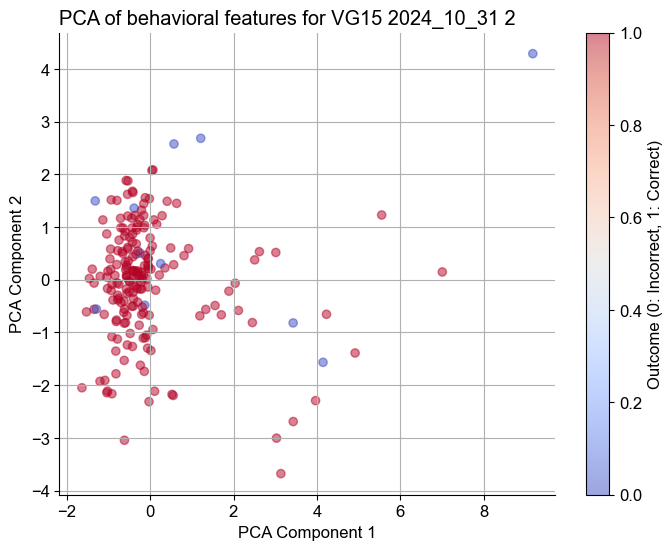

In [56]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_a.drop(columns=["outcome","category"]))
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=X_a["outcome"], cmap='coolwarm', alpha=0.5)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title(f"PCA of behavioral features for {m.name} {m.datexp} {m.blk}")
plt.colorbar(label='Outcome (0: Incorrect, 1: Correct)')
plt.grid()

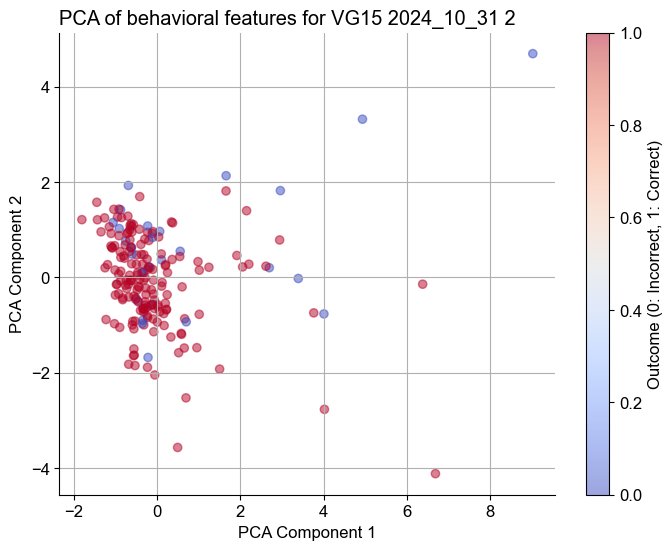

In [57]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_b.drop(columns=["outcome","category"]))
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=X_b["outcome"], cmap='coolwarm', alpha=0.5)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title(f"PCA of behavioral features for {m.name} {m.datexp} {m.blk}")
plt.colorbar(label='Outcome (0: Incorrect, 1: Correct)')
plt.grid()

Text(0.5, 1.05, 'VG15 2024_10_31 2')

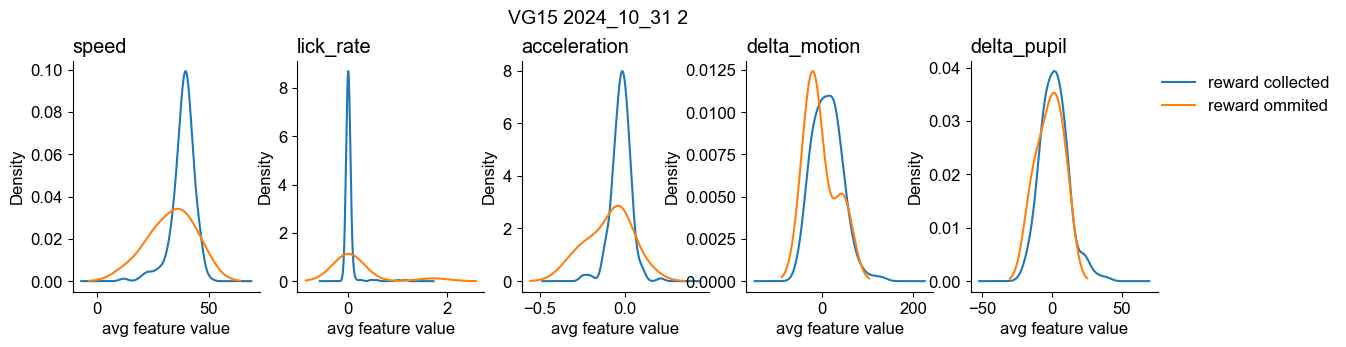

In [58]:
fig, ax = plt.subplots(1,5, figsize=(14, 3))
for iff, feature in enumerate(["speed", "lick_rate", "acceleration", "delta_motion", "delta_pupil"]):
    X_a.query("outcome==1")[feature].plot(kind="kde", ax=ax[iff], color="tab:blue", label="reward collected")
    X_a.query("outcome==0")[feature].plot(kind="kde", ax=ax[iff], color="tab:orange", label="reward ommited")
    ax[iff].set_title(feature)
    ax[iff].set_xlabel("avg feature value")
    ax[iff].set_ylabel("Density")
ax[-1].legend(loc="upper right", frameon=False, bbox_to_anchor=(2, 1))
fig.suptitle(f"{m.name} {m.datexp} {m.blk}", fontsize=fs_title, y=1.05)



Text(0.5, 1.05, 'VG15 2024_10_31 2')

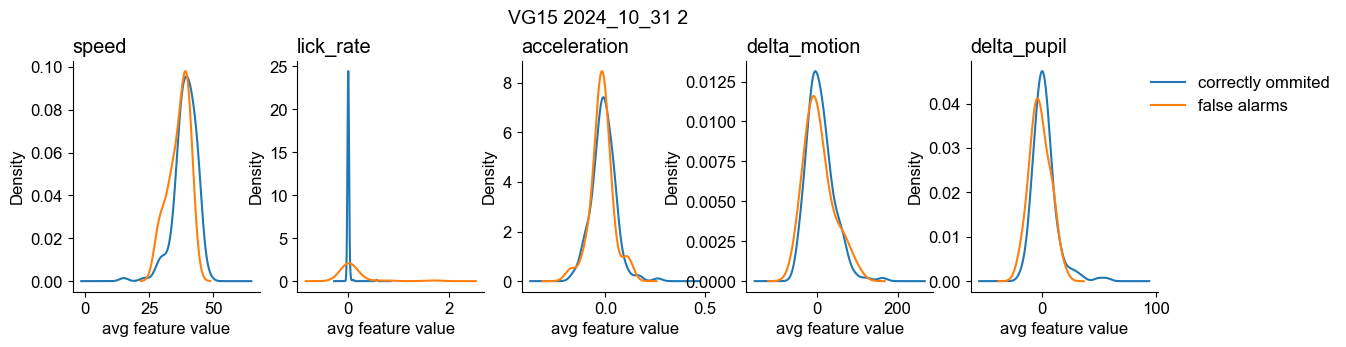

In [59]:
fig, ax = plt.subplots(1,5, figsize=(14, 3))
for iff, feature in enumerate(["speed", "lick_rate", "acceleration", "delta_motion", "delta_pupil"]):
    X_b.query("outcome==1")[feature].plot(kind="kde", ax=ax[iff], color="tab:blue", label="correctly ommited")
    X_b.query("outcome==0")[feature].plot(kind="kde", ax=ax[iff], color="tab:orange", label="false alarms")
    ax[iff].set_title(feature)
    ax[iff].set_xlabel("avg feature value")
    ax[iff].set_ylabel("Density")
ax[-1].legend(loc="upper right", frameon=False, bbox_to_anchor=(2, 1))
fig.suptitle(f"{m.name} {m.datexp} {m.blk}", fontsize=fs_title, y=1.05)

In [60]:
correct_A = X_a.query("outcome==1").index
incorrect_A = X_a.query("outcome==0").index
correct_B = X_b.query("outcome==1").index
incorrect_B = X_b.query("outcome==0").index


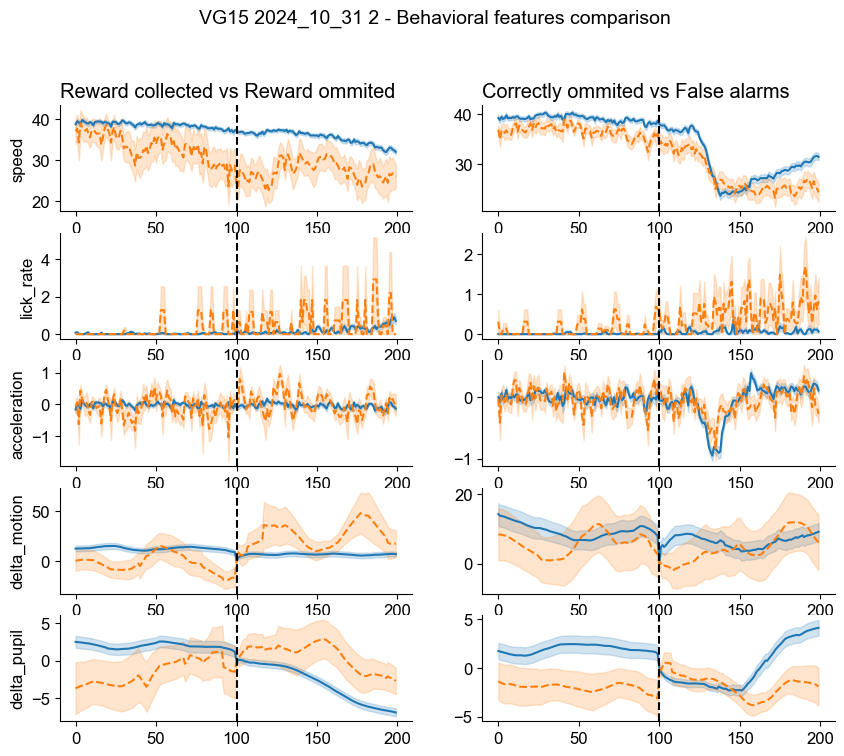

In [61]:
fig, ax = plt.subplots(5, 2, figsize=(10, 8))
centered_speed = center_feature(m, speed)
centered_lick_rate = center_feature(m, lick_rate)
centered_acc = center_feature(m, acc)
centered_delta_motion = center_feature(m, delta_motion)
centered_delta_pupil = center_feature(m, delta_pupil)
correct_A = X_a.query("outcome==1").index
incorrect_A = X_a.query("outcome==0").index
correct_B = X_b.query("outcome==1").index
incorrect_B = X_b.query("outcome==0").index
features_names = ["speed", "lick_rate", "acceleration", "delta_motion", "delta_pupil"]
ax[0, 0].set_title("Reward collected vs Reward ommited")
ax[0, 1].set_title("Correctly ommited vs False alarms")
#ax[0, 2].set_title("Reward collected vs Reward ommited")
#ax[0, 3].set_title("Correctly ommited vs False alarms")
fig.suptitle(f"{m.name} {m.datexp} {m.blk} - Behavioral features comparison", fontsize=fs_title, y=1)
for iff, feature in enumerate([centered_speed, centered_lick_rate, centered_acc, centered_delta_motion, centered_delta_pupil]):
    feature = feature[:, :200]  # remove intertrial period
    f_cA_mean = feature[correct_A].mean(0)
    f_cA_sem = sem(feature[correct_A], axis=0)
    f_iA_mean = feature[incorrect_A].mean(0)
    f_iA_sem = sem(feature[incorrect_A], axis=0)
    f_cB_mean = feature[correct_B].mean(0)
    f_cB_sem = sem(feature[correct_B], axis=0)
    f_iB_mean = feature[incorrect_B].mean(0)
    f_iB_sem = sem(feature[incorrect_B], axis=0)
    ax[iff, 0].plot(f_cA_mean, label="reward collected")
    ax[iff, 0].fill_between(np.arange(200), f_cA_mean + f_cA_sem, f_cA_mean - f_cA_sem, color="tab:blue", alpha=0.2)
    ax[iff, 0].plot(f_iA_mean, label="reward ommited", linestyle="--")
    ax[iff, 0].fill_between(np.arange(200), f_iA_mean + f_iA_sem, f_iA_mean - f_iA_sem, color="tab:orange", alpha=0.2)
    ax[iff, 0].set_ylabel(f"{features_names[iff]}")
    ax[iff, 1].plot(f_cB_mean, label="correctly ommited")
    ax[iff, 1].fill_between(np.arange(200), f_cB_mean + f_cB_sem, f_cB_mean - f_cB_sem, color="tab:blue", alpha=0.2)
    ax[iff, 1].plot(f_iB_mean, label="false alarms", linestyle="--")
    ax[iff, 1].fill_between(np.arange(200), f_iB_mean + f_iB_sem, f_iB_mean - f_iB_sem, color="tab:orange", alpha=0.2)
    ax[iff, 0].axvline(100, color="k", linestyle="--")
    ax[iff, 1].axvline(100, color="k", linestyle="--")
    #ax[iff, 2].hist(feature[correct_A,:100].mean(1), color="tab:blue", bins=20, alpha=0.5, label="reward collected")
    #ax[iff, 2].hist(feature[incorrect_A,:100].mean(1), color="tab:orange", bins=20, alpha=0.5, label="reward ommited")
    #ax[iff, 2].set_ylabel(f"ITI avg")
    #ax[iff, 3].hist(feature[correct_B,:100].mean(1), color="tab:blue", bins=20,  alpha=0.5, label="correctly ommited")
    #ax[iff, 3].hist(feature[incorrect_B,:100].mean(1), color="tab:orange", bins=20, alpha=0.5, label="false alarms")
    #ax[iff, 3].set_ylabel(f"ITI avg")

### Cognitive State Indicators from Pupil Size and Facial Motion Energy in Mice

| **Cognitive Component** | **Pupil Size** | **Facial Motion Energy** | **Key References** |
|--------------------------|----------------|---------------------------|--------------------|
| **Decision Making**      | Dilates during deliberation and just before choice; larger with uncertainty | Increases during decision execution and motor preparation | Murphy et al., 2014 (PNAS); Musall et al., 2019 (Nat Neurosci); Reimer et al., 2014 (J Neurosci) |
| **Engagement**           | Higher baseline when engaged; constricts with disengagement | Low but sustained motion during engagement; drops with disengagement or rises during unrelated grooming | McGinley et al., 2015 (Science); Stringer et al., 2019 (Nature); Salkoff et al., 2020 (eLife) |
| **Attention**            | Transient dilation to salient or expected stimuli | Small increases in motion (e.g., whisker, snout) when anticipating or detecting stimuli | Reimer et al., 2016 (Neuron); Steinmetz et al., 2019 (Nature) |